In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paramaggarwal_fashion_product_images_small_path = kagglehub.dataset_download('paramaggarwal/fashion-product-images-small')

print('Data source import complete.')


100%|██████████| 565M/565M [00:26<00:00, 22.2MB/s]

Extracting files...


Data source import complete.


## Code Starting

In [123]:
import os
import pandas as pd
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dense, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
df = pd.read_csv(paramaggarwal_fashion_product_images_small_path+"/styles.csv", on_bad_lines="skip")

df=df.dropna()
df=df.reset_index()

In [113]:
df

,index,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...,...
44072,44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44073,44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44074,44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44075,44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [114]:
columns_to_drop = ["year", "productDisplayName", "masterCategory", "articleType","usage"]
drop_cols=[cols for cols in columns_to_drop if cols in df.columns]
df=df.drop(drop_cols,axis=1)

In [115]:
image_dir = paramaggarwal_fashion_product_images_small_path+"/images"

In [116]:
df['image_path'] = df['id'].apply(lambda x: str(x) + ".jpg")

## Exploratory Data Analysis

In [117]:
df["subCategory"].value_counts()

,count
subCategory,
Topwear,15387
Shoes,7323
Bags,3053
Bottomwear,2686
Watches,2542
Innerwear,1806
Jewellery,1079
Eyewear,1073
Fragrance,1001


In [118]:
subcategory_counts = df["subCategory"].value_counts()
filtered_subcategories = subcategory_counts[subcategory_counts > 1000]

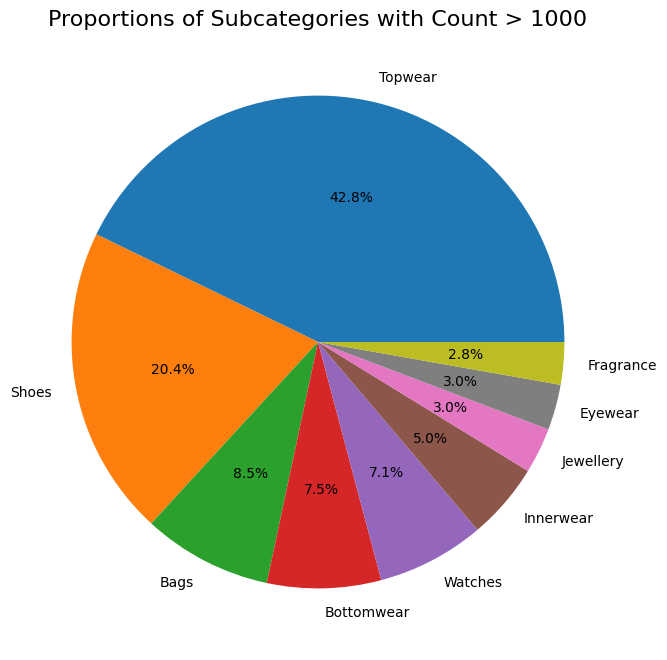

In [129]:
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_subcategories.values,
    labels=filtered_subcategories.index,
    autopct="%1.1f%%",
)
plt.title("Proportions of Subcategories with Count > 1000", fontsize=16)
plt.show()

In [130]:
basecolour_counts = df["baseColour"].value_counts()
filtered_basecolour = basecolour_counts[basecolour_counts > 300]

<ipython-input-135-572bfb13cd58>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


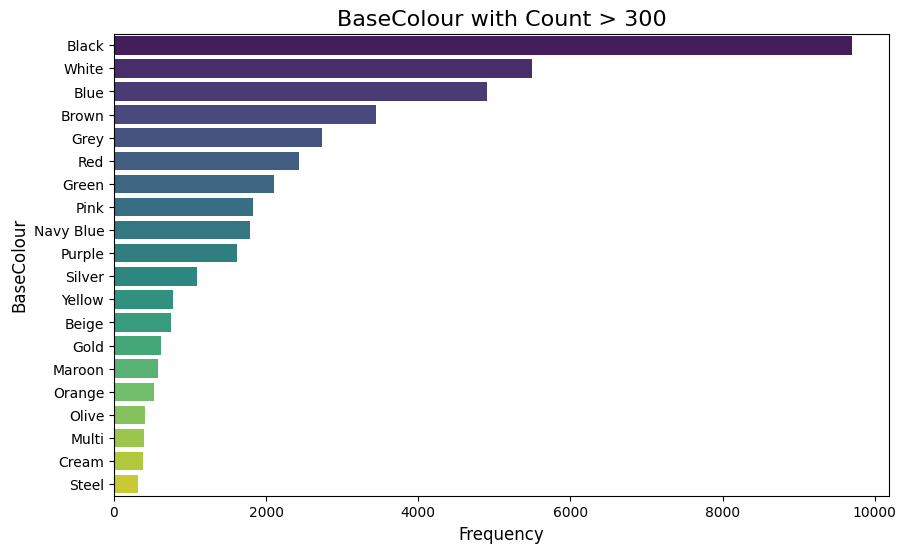

In [135]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=filtered_basecolour.values,
    y=filtered_basecolour.index,
    palette="viridis"
)
plt.title("BaseColour with Count > 300", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("BaseColour", fontsize=12)
plt.show()

In [136]:
gender_mapping = {
    "Boys": "Men",
    "Girls": "Women"
}

In [137]:
df["gender"] = df["gender"].replace(gender_mapping)

In [139]:
df["gender"].value_counts()

,count
gender,
Men,22939
Women,19012
Unisex,2126


<ipython-input-140-f672107b4814>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


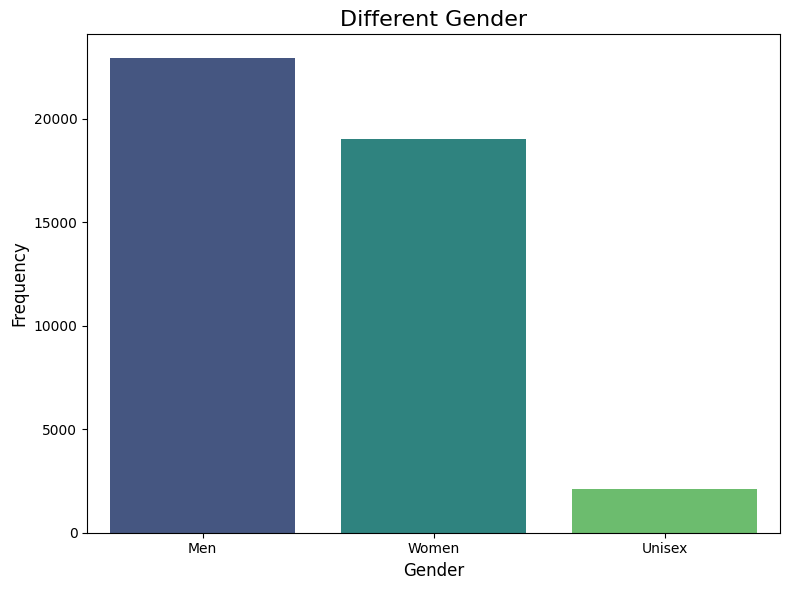

In [140]:
gender_counts = df["gender"].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(
    x=gender_counts.index,
    y=gender_counts.values,
    palette="viridis"
)
plt.title("Different Gender", fontsize=16)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

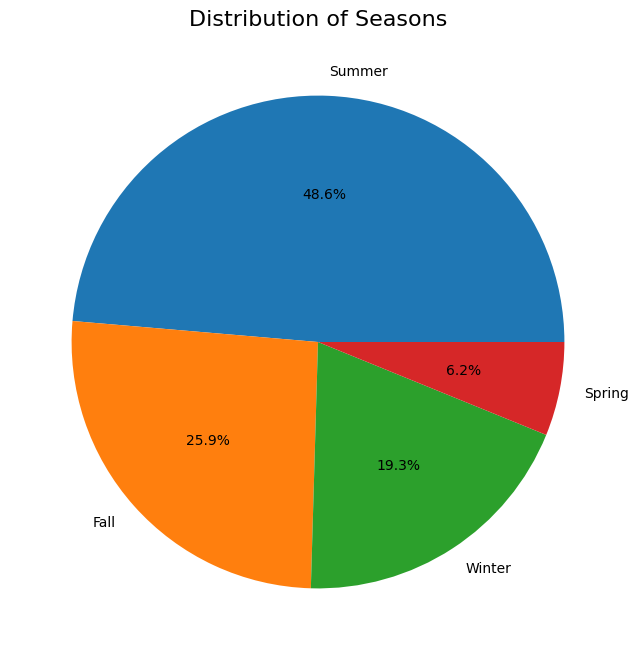

In [143]:
season_counts = df["season"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(
    season_counts.values,
    labels=season_counts.index,
    autopct="%1.1f%%",
)
plt.title("Distribution of Seasons", fontsize=16)
plt.show()

## Model Building

In [144]:
df = df[df["subCategory"].map(df["subCategory"].value_counts()) > 1000]
df = df[df["baseColour"].map(df["baseColour"].value_counts()) > 300]
df=df.reset_index()

In [145]:
df=df.drop(["level_0","index","id"],axis=1)

In [146]:
df

,gender,subCategory,baseColour,season,image_path
0,Men,Topwear,Navy Blue,Fall,15970.jpg
1,Men,Bottomwear,Blue,Summer,39386.jpg
2,Women,Watches,Silver,Winter,59263.jpg
3,Men,Bottomwear,Black,Fall,21379.jpg
4,Men,Topwear,Grey,Summer,53759.jpg
...,...,...,...,...,...
33498,Women,Topwear,Blue,Summer,42234.jpg
33499,Men,Shoes,White,Summer,17036.jpg
33500,Men,Topwear,Blue,Fall,18842.jpg
33501,Women,Fragrance,Blue,Spring,46694.jpg


In [147]:
label_encoders = {}
target_columns = ["gender", "baseColour", "subCategory", "season"]

for col in target_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [148]:
df

,gender,subCategory,baseColour,season,image_path
0,0,7,8,0,15970.jpg
1,0,1,2,2,39386.jpg
2,2,8,14,3,59263.jpg
3,0,1,1,0,21379.jpg
4,0,7,6,2,53759.jpg
...,...,...,...,...,...
33498,2,7,2,2,42234.jpg
33499,0,6,15,2,17036.jpg
33500,0,7,2,0,18842.jpg
33501,2,3,2,1,46694.jpg


In [85]:
len(label_encoders["gender"].classes_)

3

In [86]:
def image_data_generator(generator, dataframe, directory, x_col, y_col, target_size, batch_size, subset):

    data_gen = generator.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode="raw",
        subset=subset,
        shuffle=True
    )
    while True:
      x_batches, y_batches = next(data_gen)
      y_tuples = tuple(y_batches[:, i] for i in range(y_batches.shape[1]))
      yield x_batches, y_tuples

datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.25)

train_data_generator = image_data_generator(
    datagen, df, image_dir, "image_path", target_columns,
    target_size=(224, 224), batch_size=32, subset="training"
)

validation_data_generator = image_data_generator(
    datagen, df, image_dir, "image_path", target_columns,
    target_size=(224, 224), batch_size=32, subset="validation"
)

In [87]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

Input_layer = Input(shape=(224, 224, 3))

layer_01 = base_model(Input_layer)
layer_02 = GlobalAveragePooling2D()(layer_01)
layer_03 = Dense(256, activation="relu")(layer_02)
layer_03_BN = BatchNormalization()(layer_03)
layer_04 = Dropout(0.3)(layer_03_BN)
layer_05 = Dense(128, activation="relu")(layer_04)
layer_05_BN = BatchNormalization()(layer_05)
layer_06 = Dropout(0.3)(layer_05_BN)


Gender_output = Dense(len(label_encoders["gender"].classes_), activation="softmax", name="Gender_output")(layer_06)
BaseColour_output = Dense(len(label_encoders["baseColour"].classes_), activation="softmax", name="BaseColour_output")(layer_06)
SubCategory_output = Dense(len(label_encoders["subCategory"].classes_), activation="softmax", name="SubCategory_output")(layer_06)
Season_output = Dense(len(label_encoders["season"].classes_), activation="softmax", name="Season_output")(layer_06)

In [88]:
model = Model(inputs=[Input_layer], outputs=[Gender_output, BaseColour_output, SubCategory_output, Season_output])

In [89]:
model.compile(
    optimizer='adam',
    loss={
        'Gender_output': 'sparse_categorical_crossentropy',
        'BaseColour_output': 'sparse_categorical_crossentropy',
        'SubCategory_output': 'sparse_categorical_crossentropy',
        'Season_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'Gender_output': ['accuracy'],
        'BaseColour_output': ['accuracy'],
        'SubCategory_output': ['accuracy'],
        'Season_output': ['accuracy']
    }
)

In [90]:
batch_size=32
steps_per_epoch = len(df) // batch_size
validation_steps = int(len(df) * 0.25) // batch_size

In [91]:
model.fit(
    train_data_generator,
    validation_data=validation_data_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,
    verbose=1
)

Found 25125 validated image filenames.
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1301']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1046/1046 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - BaseColour_output_accuracy: 0.3511 - BaseColour_output_loss: 2.2867 - Gender_output_accuracy: 0.7676 - Gender_output_loss: 0.6165 - Season_output_accuracy: 0.5643 - Season_output_loss: 1.0897 - SubCategory_output_accuracy: 0.9019 - SubCategory_output_loss: 0.3355 - loss: 4.3285Found 8374 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1301']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1046/1046 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - BaseColour_output_accuracy: 0.3511 - BaseColour_output_loss: 2.2864 - Gender_output_accuracy: 0.7677 - Gender_output_loss: 0.6164 - Season_output_accuracy: 0.5644 - Season_output_loss: 1.0895 - SubCategory_output_accuracy: 0.9019 - SubCategory_output_loss: 0.3353 - loss: 4.3277 - val_BaseColour_output_accuracy: 0.5334 - val_BaseColour_output_loss: 1.4432 - val_Gender_output_accuracy: 0.8861 - val_Gender_output_loss: 0.3171 - val_Season_output_accuracy: 0.6689 - val_Season_output_loss: 0.7534 - val_SubCategory_output_accuracy: 0.9794 - val_SubCategory_output_loss: 0.0759 - val_loss: 2.5897
Epoch 2/10
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 64s 61ms/step - BaseColour_output_accuracy: 0.5099 - BaseColour_output_loss: 1.5668 - Gender_output_accuracy: 0.8704 - Gender_output_loss: 0.3419 - Season_output_accuracy: 0.6567 - Season_output_loss: 0.7841 - SubCategory_output_accuracy: 0.9739 - SubCategory_output_loss: 0.0936 - loss: 2.7862 - val_BaseColour_out

## Saving and Loading the Model

In [92]:
model.save("fashion_model.h5")

In [93]:
model = load_model("fashion_model.h5")

## Testing the model

In [94]:
def preprocess_image(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [151]:
image_paths = ["/content/test_01.jpg", "/content/test_02.jpg", "/content/test_03.jpg"]

for img_path in image_paths:
    img_array = preprocess_image(img_path)
    predictions = model.predict(img_array)
    gender_prediction = label_encoders["gender"].inverse_transform([np.argmax(predictions[0])])
    baseColour_prediction = label_encoders["baseColour"].inverse_transform([np.argmax(predictions[1])])
    subCategory_prediction = label_encoders["subCategory"].inverse_transform([np.argmax(predictions[2])])
    season_prediction = label_encoders["season"].inverse_transform([np.argmax(predictions[3])])

    print(f"Image: {img_path}")
    print(f"Predicted Gender: {gender_prediction[0]}")
    print(f"Predicted Base Colour: {baseColour_prediction[0]}")
    print(f"Predicted SubCategory: {subCategory_prediction[0]}")
    print(f"Predicted Season: {season_prediction[0]}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: /content/test_01.jpg
Predicted Gender: Men
Predicted Base Colour: White
Predicted SubCategory: Topwear
Predicted Season: Summer
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Image: /content/test_02.jpg
Predicted Gender: Women
Predicted Base Colour: White
Predicted SubCategory: Fragrance
Predicted Season: Spring
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: /content/test_03.jpg
Predicted Gender: Women
Predicted Base Colour: Black
Predicted SubCategory: Jewellery
Predicted Season: Winter
--------------------------------------------------
